# Semantic Search with FAISS

In [22]:
import torch
from transformers import AutoTokenizer, AutoModel
from matplotlib import pyplot as plt
import seaborn as sns

In [23]:
sentences = [
    "I took my dog for a walk",
    "Today is going to rain",
    "I took my cat for a walk"
]

In [24]:
model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [25]:
encoded_input = tokenizer(sentences, padding=True, truncation=True,  return_tensors = "pt")

In [26]:
encoded_input

{'input_ids': tensor([[ 101, 1045, 2165, 2026, 3899, 2005, 1037, 3328,  102],
        [ 101, 2651, 2003, 2183, 2000, 4542,  102,    0,    0],
        [ 101, 1045, 2165, 2026, 4937, 2005, 1037, 3328,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [27]:
with torch.no_grad():
    model_output = model(**encoded_input)

In [28]:
token_embeddings = model_output.last_hidden_state

In [29]:
token_embeddings.shape

torch.Size([3, 9, 384])

In [30]:
import torch.nn.functional as F

In [31]:
encoded_input['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float().shape

torch.Size([3, 9, 384])

In [32]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
# Normalize the embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
print(f'Sentence embeddings shape: {sentence_embeddings.size()}')

Sentence embeddings shape: torch.Size([3, 384])


In [33]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

sentence_embeddings = sentence_embeddings.detach().numpy()
scores = np.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0]))

for idx in range(sentence_embeddings.shape[0]):
    scores[idx, :] = cosine_similarity(sentence_embeddings[idx][None], sentence_embeddings)[0]

In [34]:
scores.shape

(3, 3)

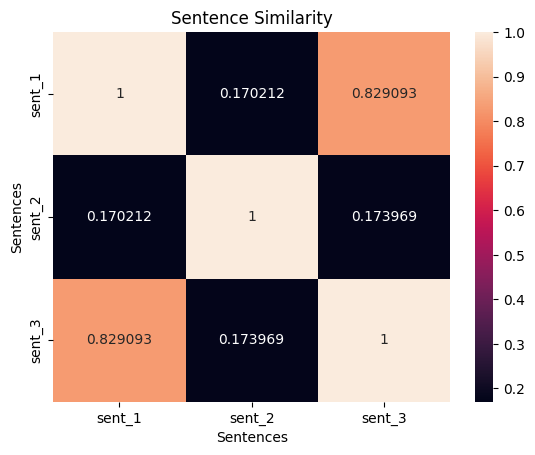

In [36]:
ax= plt.subplot()
sns.heatmap(scores, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Sentences');
ax.set_ylabel('Sentences'); 
ax.set_title('Sentence Similarity'); 
labels = ['sent_1', 'sent_2', 'sent_3']
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [45]:
sentence_embeddings[0].shape

(384,)

In [28]:
sentence_embeddings.shape

(3, 384)

In [40]:
sentence_embeddings[0][None].shape

(1, 384)

In [42]:
cosine_similarity(sentence_embeddings[0][None], sentence_embeddings, )

(1, 3)

In [36]:
scores[0, :].shape

(384,)

In [37]:
from datasets import load_dataset

In [38]:
squad = load_dataset("squad", split="validation[:100]")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [39]:
from datasets import load_dataset

In [40]:
load_dataset("code_search_net", "python")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
        num_rows: 412178
    })
    test: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
        num_rows: 22176
    })
    validation: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
        num_rows: 23107
    })
})